In [1]:
import pyham
from Bio import SeqIO
import os
import matplotlib.pyplot as plt
import networkx as nx

print(pyham.__version__, "   ", nx.__version__)

1.1.7     2.4


In [2]:
def locus_to_id(file):
    
    """
    This function extracts loci from a fasta file and store the information as keys in a dictionary 
    and the related protein ID as value.

    Args:
        file (:obj:`str`): path to the file of interest.

    Returns:
        a dictionary mapping the locus (:obj:`str`) with the protein ID (:obj:`str`).
    """
    
    locus_to_id = {}
    for seq_record in SeqIO.parse(file, 'fasta'):
        locus_to_id[seq_record.description.split('locus: ')[-1]] = seq_record.description
        
    return locus_to_id


def get_locus(directory):
    
    """
    This function goes through each file of a folder and build a dictionary containing loci 
    as keys and the related protein ID as values. For each entry in the dictionary, the function 
    updates the corresponding :obj:`pyham.abstractgene.Gene` by adding its locus.

    Args:
        directory (:obj:`str`): directory of interest.

    Returns:
        xxx
    """

    path = directory
    for file in os.listdir(path):
        ##print('File:', file)
        path_to_file = path + '/' + file
        locus_dictionary = locus_to_id(path_to_file)
 
        for (loci, gene_id) in locus_dictionary.items():
            gene = ham_analysis_no_name.get_genes_by_external_id(gene_id)
            
            # each gene should only map to 1 other gene, so should always be length 1...
            assert len(gene) == 1, 'gene_id maps to multiple entries'
            gene[0].locus = loci
            #for element in gene:
            #    element.locus = loci
                
        ham_analysis_no_name.get_extant_genome_by_name('.'.join(file.split('.')[:-1])).locus_assignment = True
        

def get_gene_by_locus(genome, locus):
    
    """
    Get a :obj:`pyham.abstractgene.Gene` that match the query locus. 

    Args:
        genome (:obj:`pyham.genome.Genome`): extant genome of interest.
        locus (:obj:`int`): locus.

    Returns:
        :obj:`pyham.abstractgene.Gene`.
    """
    
    for gene in genome.genes:
        if int(gene.locus) == locus:
            return gene 
    
    return None

def assign_neighbors(genome):
    
    """
    This function assigns neighbors to each :obj:`pyham.abstractgene.Gene` or :obj:`pyham.abstractgene.HOG`.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        xxx
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        
        for extant_gene in genome.genes:
            extant_gene.neighbors = (get_gene_by_locus(genome, int(extant_gene.locus)-1), 
                                     get_gene_by_locus(genome, int(extant_gene.locus)+1))            
                        
    if isinstance(genome, pyham.AncestralGenome):
    
        for ancestral_gene in genome.genes:  
            
            # test here, see if does the same thing, children should only be direct descendants?
            #children = [child for child in ancestral_gene.children]
            children = ancestral_gene.children
            
            ######################################################################################
            # Dictionary containing genome names as keys (i.e. SE004) and a list of children as value #
            ######################################################################################
            
            genome_dict = {}  
            
            for child in children:
                if child.genome.name in genome_dict:
                    genome_dict[child.genome.name].append(child) # if already in dictionary, add it (duplicate)
                else:
                    genome_dict[child.genome.name] = [child] # otherwise add the child
            
            ############################################
            # Children are replaced by their neighbors #      
            ############################################
            
            for genome, gene_collection in genome_dict.items(): #stoca 
                for i in range(len(gene_collection)):
                    gene_collection[i] = list(gene_collection[i].neighbors)
            
            ################################################################################
            # Dictionary containing genomes as keys (i.e. SE004) and a list of parent HOGs #
            ################################################################################
            
            parent_dict = {} # gets a list of all potential neighboring hogs to the ancestral_gene
            for genome, neighbors_collection in genome_dict.items(): #stoca 
                for neighbors_pair in neighbors_collection:
                    for neighbor in neighbors_pair: # don't really need the for loop bc only ever 2 neighbors
                        if genome in parent_dict:   ## KJG - I don't understand this if/else - if we already put the focal genome in the parent dictionary, we do the same thing as if we didn't?
                            if neighbor == None:
                                parent_dict[genome].add(None)
                            else:
                                if neighbor.parent != ancestral_gene: #if theres' a duplication this might be true
                                    parent_dict[genome].add(neighbor.parent) #add the neighbors parents - the neighboring hogs
                        else:
                            if neighbor == None:
                                parent_dict[genome] = {None}    ## ah, this makes focal genome 'none' while above does 'add(None)' in addition to current genome?
                            else:
                                if neighbor.parent != ancestral_gene: # fill the parent dict by looking to see 
                                    parent_dict[genome] = {neighbor.parent}  ## again, no 'add', just make

            l = []  # List of sets
            for genome, parent in parent_dict.items():  
                l.append(parent)  # parent is a set
                ancestral_gene.list_parents = l            # List of potential neighbors in case of conflict
                
            final_neighbors = list(l[0].intersection(*l))  # Intersection of the sets
            
            if len(final_neighbors) == 2:
                ancestral_gene.neighbors = tuple(final_neighbors)
                print("fin", ancestral_gene.neighbors)
            
            elif len(final_neighbors) == 1:
                none_counter = 0
                potential_neighbor = None
                
                for collection in l:
                    if len(collection) == 2:
                        for element in collection:
                            if element == final_neighbors[0]:
                                continue
                            elif element == None:
                                none_counter += 1
                            else:
                                potential_neighbor = element
                
                    else:
                        break
                
                if none_counter == 1:  # To deal with missing orthology
                    final_neighbors.append(potential_neighbor)
                
                if len(final_neighbors) == 1:
                    final_neighbors.append(None)
                    ancestral_gene.neighbors = tuple(final_neighbors)
                else:  
                    ancestral_gene.neighbors = tuple(final_neighbors)
            
            elif len(final_neighbors) == 0 or len(final_neighbors) > 2:
                final_neighbors = [None, None]
                ancestral_gene.neighbors = tuple(final_neighbors)


## Graph Theory Approach

In [275]:
def make_synteny_graph(genome):
    
    """
    This function makes network graphs at the given level (genome) in the species tree.

    Args:
        genome (:obj:`pyham.genome.Genome`): extant or ancestral genome of interest.

    Returns:
        either a single graph for extant genes or multiple graphs for ancestral genes. 
        a graph for the HOGs and for each set of children from those HOGs at an ancestral node
    """
    
    if isinstance(genome, pyham.ExtantGenome):
        # make the graphs
        all_graphs = []
        extant_gene_graph = nx.Graph()
        parent_gene_graph = nx.Graph()
        ##extant_gene_graph = nx.MultiGraph() # only if I needed multiple edges for the same pair of nodes
        
        extant_gene_graph.add_node("start")
        parent_gene_graph.add_node("start")

        old_node = "start"
        old_parent_node = "start"
        for extant_gene in genome.genes:  
            new_node = (get_gene_by_locus(genome, int(extant_gene.locus)))
            # add the new nodes to a graph
            extant_gene_graph.add_node(new_node)
            # create edges between the correct nodes
            extant_gene_graph.add_edge(old_node, new_node)
            # save the old node to create the next edge
            old_node = new_node
            
            # add the new parent nodes
            new_parent_node = new_node.parent 
            # check there are no nodes that lack a HOG parent, if yes, don't have in the parent graph
            if new_parent_node == None:
                print("an extant gene has no parent HOG, don't add synteny in the parent")
            else:
                parent_gene_graph.add_node(new_parent_node)
                parent_gene_graph.add_edge(old_parent_node, new_parent_node)
                old_parent_node = new_parent_node
                
        extant_gene_graph.remove_node("start") # remove it, was only there to make the edges as we went along
        parent_gene_graph.remove_node("start") # remove it, was only there to make the edges as we went along
        
        all_graphs.append(extant_gene_graph)
        all_graphs.append(parent_gene_graph)
        
        return(all_graphs)

    
    if isinstance(genome, pyham.AncestralGenome):
        # at an ancestral node, we build the graph based on the graphs at the descendant node
        # so for now just make all the vertices in the graph, and in another function, compare to descendant to connect edges
        
       # make the graphs
        all_graphs = []
        ancestral_gene_graph = nx.Graph()
        parent_gene_graph = nx.Graph()
        
        for ancestral_gene in genome.genes:
            ancestral_gene_graph.add_node(ancestral_gene)
            if ancestral_gene.parent == None:
                print("an ancestral gene has no parent HOG, don't add synteny in the parent")
            else:
                parent_gene_graph.add_node(ancestral_gene.parent)

            if len(ancestral_gene.children) > 2:
                print("fix problem, there is a polytomy")     
                
        all_graphs.append(ancestral_gene_graph)
        all_graphs.append(parent_gene_graph)
        
        return(all_graphs)

In [276]:
def map_edges_to_parent(tree_node):
    """
    This function takes a node containing a current and a parent network graph with different node labels
    and assigns the edges from the current graph to the parent graph using a dictionary to map the same nodes

    Args:
        genome (:obj:`pyham.genome.Genome`): genome of interest.

    Returns:
        xxx
    """

    # copy child level synteny to parent level (by copying the whole graph)
    tree_node.graph[1] = tree_node.graph[0]

    # put back the proper parent level node names
    tree_node.graph[1] = nx.relabel_nodes(tree_node.graph[0], lambda x: x.parent)    


In [277]:
def compare_synteny_graphs(tree_node):
    
    """
    This function assigns syntenic edges at an ancestral node in the species tree by
    comparing the network graphs from its two descendant graphs. If there are more than
    two descendants, the code will not function properly.

    Args:
        genome (:obj:`pyham.genome.Genome`): genome of interest.

    Returns:
        xxx
    """
    
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        print("synteny already assigned for extant genome")
        
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        print("assign ancestral synteny")
        
        # take this tree node
        # get the descendant tree nodes (and their associated parent graphs)
        descendants = tree_node.children
        if len(descendants) > 2:
            print("fix problem, there is a polytomy")

        temp1 = descendants[0].graph[1] # the parent graph of descendant 1
        for edg in temp1.edges:
            if tree_node.graph[0].has_edge(edg[0], edg[1]):
                # we added this one before, just increase the weight by one
                tree_node.graph[0][edg[0]][edg[1]]['weight'] += 1
            else:
                # new edge. add with weight=1
                tree_node.graph[0].add_edge(edg[0], edg[1], weight=1)

        # add edges from descendant2
        temp2 = descendants[1].graph[1] # the parent graph of descendant 2
        for edg in temp2.edges:
            if tree_node.graph[0].has_edge(edg[0], edg[1]):
                # we added this one before, just increase the weight by one
                tree_node.graph[0][edg[0]][edg[1]]['weight'] += 1
            else:
                # new edge. add with weight=1
                tree_node.graph[0].add_edge(edg[0], edg[1], weight=1) 
        
        # add those edges now to the parent graph, because that is needed for the upper level
        map_edges_to_parent(tree_node)


In [278]:
def intersection(list1, list2): 
    list3 = [value for value in list1 if value in list2] 
    return list3

In [279]:
def settle_path(tree_node):

    """
    This function 
    Args:
        genome (:obj:`pyham.genome.Genome`): genome of interest.

    Returns:
        xxx
    """
      
    # find all nodes with 3 edges (neighbors)
    # (also end node of graph, in case it's useful at some point)

    end_nodes=[]
    three_edges=[]

    # find all nodes with three neighbors 
    # (also end node of graph, in case it's useful at some point

    for deg in tree_node.graph[0].degree:
        if deg[1] == 1:
            end_nodes.append(deg)
        if deg[1] == 3:
            three_edges.append(deg)

    # get the neighbors of each of those nodes, because I'll want to break the edge 
    #  if there's a neighbor with three edges also

    # list of dictionaries to contain neighbors of the three-edged nodes
    num_three_edges=len(three_edges)
    neighbors_dict_list=[dict() for x in range(num_three_edges)]
    iter=0
    for n in three_edges:
        neighbors_dict_list[iter] = tree_node.graph[0].neighbors(n[0])
        iter+=1

    # for a given node, do any neighbors also have degree 3?
    edge_share=[]
    for nod in range(num_three_edges):
        for nei in neighbors_dict_list[nod]:
            if tree_node.graph[0].degree(nei) == 3:
                # then the neighbor of a node with 3 edges also has 3 edges
                edge_share.append([three_edges[nod][0], nei])      

    for i in range(0,len(edge_share)):
        for j in range(1,len(edge_share)):
            match = intersection(edge_share[i], edge_share[j])
            if len(match) == 2:
                edge_to_break = match
                # if the edge wasn't already removed, remove it now
                if tree_node.graph[0].has_edge(edge_to_break[0], edge_to_break[1]):
                    tree_node.graph[0].remove_edge(edge_to_break[0], edge_to_break[1])
                    print("break me", edge_to_break)

                    # fix weights of the other edges of these spots
                    # find the remaining path from those same two nodes
                    reweight_path = nx.all_simple_paths(tree_node.graph[0], edge_to_break[0], edge_to_break[1])
                    reweight_path_copy = nx.all_simple_paths(tree_node.graph[0], edge_to_break[0], edge_to_break[1])
                    # need the copy because the generator object isn't stored in memory, and I want to access it twice
                    path_edges = list(reweight_path)[0]
#                    print(tree_node.graph[0].edges(data=True))
#                    print("path lengths", len(list(reweight_path_copy)))
                    if len(list(reweight_path_copy)) > 1:
                        print("there is something wrong because more than one path connects the nodes where we broke an edge")
                    else: ## reweight the correct path
                        for j in range(0, len(path_edges)-1):
                            k = j+1
                            tree_node.graph[0].add_edge(path_edges[j], path_edges[k], weight=2)
                            # add those edges now to the parent graph, because that is needed for the upper level
                            map_edges_to_parent(tree_node)
                            
#                    print("path edges", path_edges)

#                    print("reweighted", tree_node.graph[0].edges(data=True))



### Functions defined above, usage tests below


--SE001_aa
synteny already assigned for extant genome

--SE003_aa
synteny already assigned for extant genome

   /-SE001_aa
--|
   \-SE003_aa
assign ancestral synteny
break me [<HOG(i2)>, <HOG(i3)>]
break me [<HOG(i21)>, <HOG(i22)>]

--SE002_aa
synteny already assigned for extant genome

      /-SE001_aa
   /-|
--|   \-SE003_aa
  |
   \-SE002_aa
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no paren

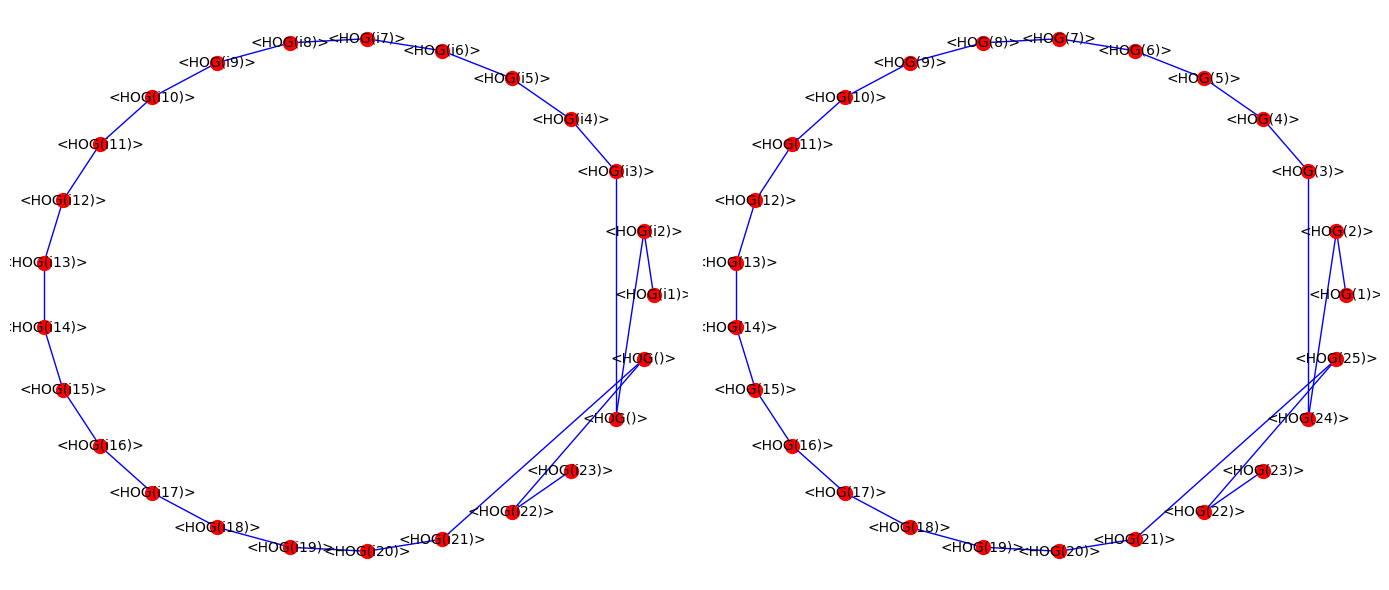

In [280]:
### TRY TWO LOSSES
nwk_path = "working_two_losses_3spp/RealTree.nwk"
# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")
# Path to OrthoXML file
orthoxml_path = "working_two_losses_3spp/Output/HierarchicalGroups.orthoxml"
ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)
get_locus('working_two_losses_3spp/DB')



## ASSIGN SYNTENY

fig=plt.figure(figsize=(14, 6), dpi= 100)
# make the first round of graphs at all nodes

plot_loc = 121
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
        
    ## AND ALSO DO THE SETTLING ALGORITHM   
    settle_path(tree_node)
    
    
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)
        
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')
        plot_loc += 1
        

plt.tight_layout()
fig.savefig("/Users/kgilbert/Documents/UNIL/SyntenyBasedOrthology/My_SyntOrtho_Code/working_two_losses_3spp/outfig_doubleloss_3spp_withSettlingAlgorithm.pdf")




--SE001_aa
SE001_aa
synteny already assigned for extant genome

--SE002_aa
SE002_aa
synteny already assigned for extant genome

--SE003_aa
SE003_aa
synteny already assigned for extant genome

   /-SE002_aa
--|
   \-SE003_aa
SE002_aa/SE003_aa
assign ancestral synteny

   /-SE001_aa
--|
  |   /-SE002_aa
   \-|
      \-SE003_aa
SE001_aa/SE002_aa/SE003_aa
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no

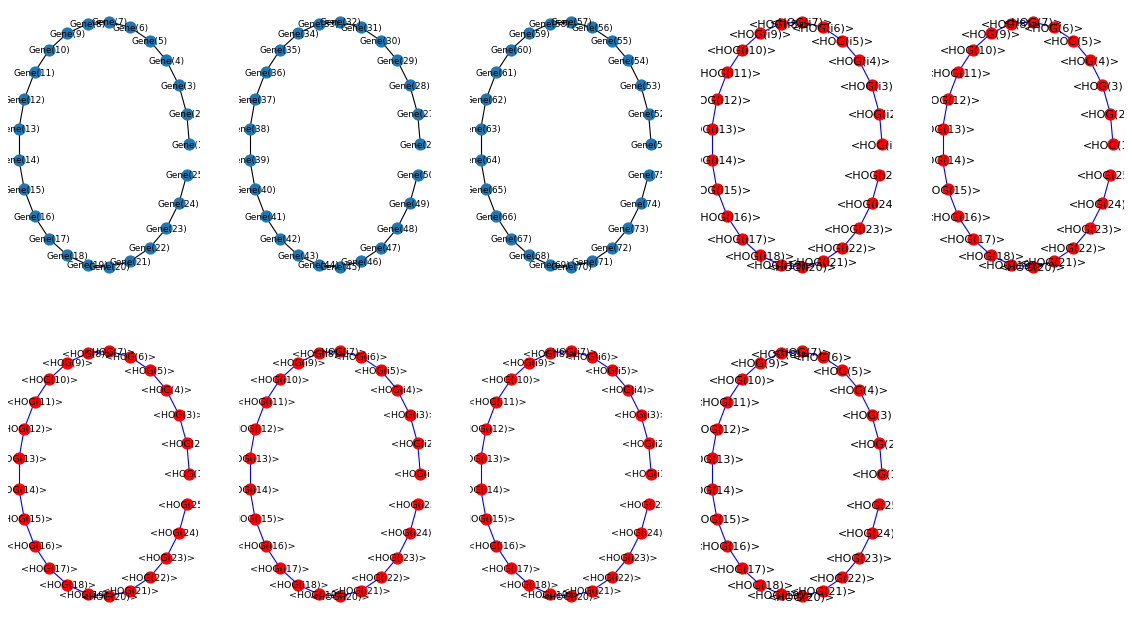

In [281]:
nwk_path = "working_perfect_3spp/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
orthoxml_path = "working_perfect_3spp/Output/HierarchicalGroups.orthoxml"

ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

get_locus('working_perfect_3spp/DB')




fig=plt.figure(figsize=(18, 10), dpi= 80)
# make the first round of graphs at all nodes

plot_loc = 251
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
    print(tree_node.genome)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
    
    # If it's an extant gene, doesn't have any weights, plot normally
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=8, node_size=100,
            pos=nx.circular_layout(tree_node.graph[0]))

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1
    
    
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)

        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), 
            node_color='r', edge_color='w')
        
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        
        
        
        
        #nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
        #    pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1
    
#    large_edges = [(u, v) for (u, v, d) in temp1.edges(data=True) if d['weight'] > 1]
#    small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]

#    nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
#        pos=nx.circular_layout(tree_node.graph[0]), 
#        node_color='r', edge_color='w')

    #nx.draw_networkx_nodes(current_graph, pos=nx.circular_layout(current_graph), node_size=100, with_labels=True)
#    nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
#                           edgelist=large_edges, width=1, edge_color='blue', style='solid')
#    nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
#                           edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')
    


### Try the gene loss case - spp1 lost a gene (gene "3")

In [284]:
nwk_path = "working_loss_3spp/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
orthoxml_path = "working_loss_3spp/Output/HierarchicalGroups.orthoxml"

ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

get_locus('working_loss_3spp/DB')


--SE001_aa
SE001_aa
synteny already assigned for extant genome

--SE003_aa
SE003_aa
synteny already assigned for extant genome

   /-SE001_aa
--|
   \-SE003_aa
SE001_aa/SE003_aa
assign ancestral synteny
break me [<HOG(i2)>, <HOG(i3)>]

--SE002_aa
SE002_aa
synteny already assigned for extant genome

      /-SE001_aa
   /-|
--|   \-SE003_aa
  |
   \-SE002_aa
SE001_aa/SE003_aa/SE002_aa
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the

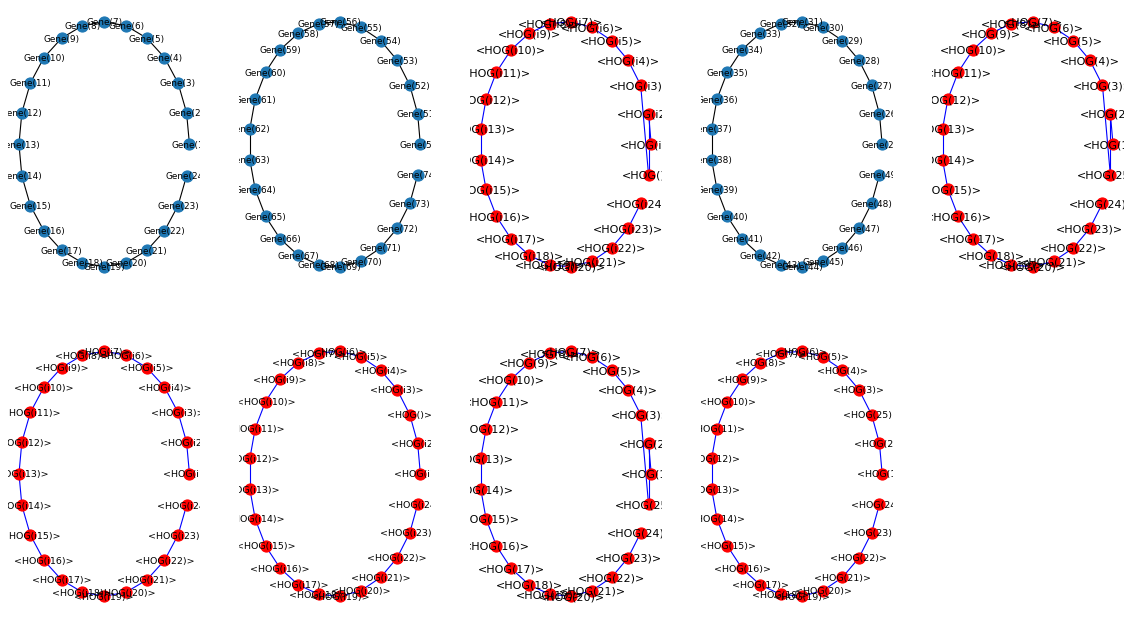

In [285]:
fig=plt.figure(figsize=(18, 10), dpi= 80)
# make the first round of graphs at all nodes

plot_loc = 251
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
    print(tree_node.genome)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
    
    ## AND ALSO DO THE SETTLING ALGORITHM   
    settle_path(tree_node)

    
    # If it's an extant gene, doesn't have any weights, plot normally
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=8, node_size=100,
            pos=nx.circular_layout(tree_node.graph[0]))

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1
    
    
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)

        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), 
            node_color='r', edge_color='w')
        
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        
        
        
        
        #nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
        #    pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1


--SE001_aa
synteny already assigned for extant genome

--SE003_aa
synteny already assigned for extant genome

   /-SE001_aa
--|
   \-SE003_aa
assign ancestral synteny
break me [<HOG(i2)>, <HOG(i3)>]

--SE002_aa
synteny already assigned for extant genome

      /-SE001_aa
   /-|
--|   \-SE003_aa
  |
   \-SE002_aa
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the pa

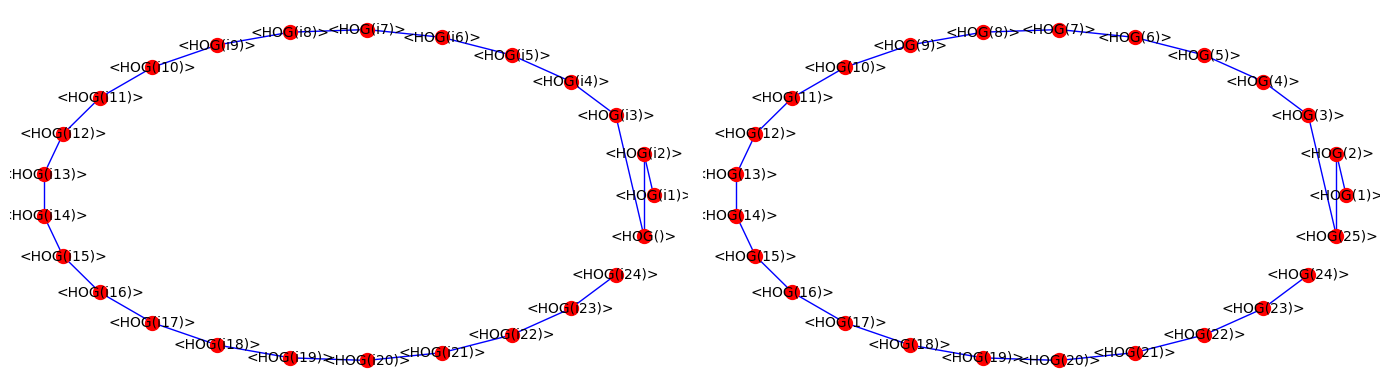

In [286]:
## LOAD DATA

nwk_path = "working_loss_3spp/RealTree.nwk"
# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")
# Path to OrthoXML file
orthoxml_path = "working_loss_3spp/Output/HierarchicalGroups.orthoxml"
ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)
get_locus('working_loss_3spp/DB')

## ASSIGN SYNTENY

fig=plt.figure(figsize=(14, 4), dpi= 100)
# make the first round of graphs at all nodes

plot_loc = 121
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
    settle_path(tree_node)
        
    
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)

        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')
        plot_loc += 1
                

plt.tight_layout()
fig.savefig("/Users/kgilbert/Documents/UNIL/SyntenyBasedOrthology/My_SyntOrtho_Code/working_loss_3spp/outfig_loss_3spp_withSettlingAlgorithm.pdf")



### Try the gene insertion case -- gene 52 has no parent HOG



--SE001_aa
SE001_aa
synteny already assigned for extant genome

--SE002_aa
SE002_aa
synteny already assigned for extant genome

--SE003_aa
SE003_aa
an extant gene has no parent HOG, don't add synteny in the parent
synteny already assigned for extant genome

   /-SE002_aa
--|
   \-SE003_aa
SE002_aa/SE003_aa
assign ancestral synteny

   /-SE001_aa
--|
  |   /-SE002_aa
   \-|
      \-SE003_aa
SE001_aa/SE002_aa/SE003_aa
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no pa

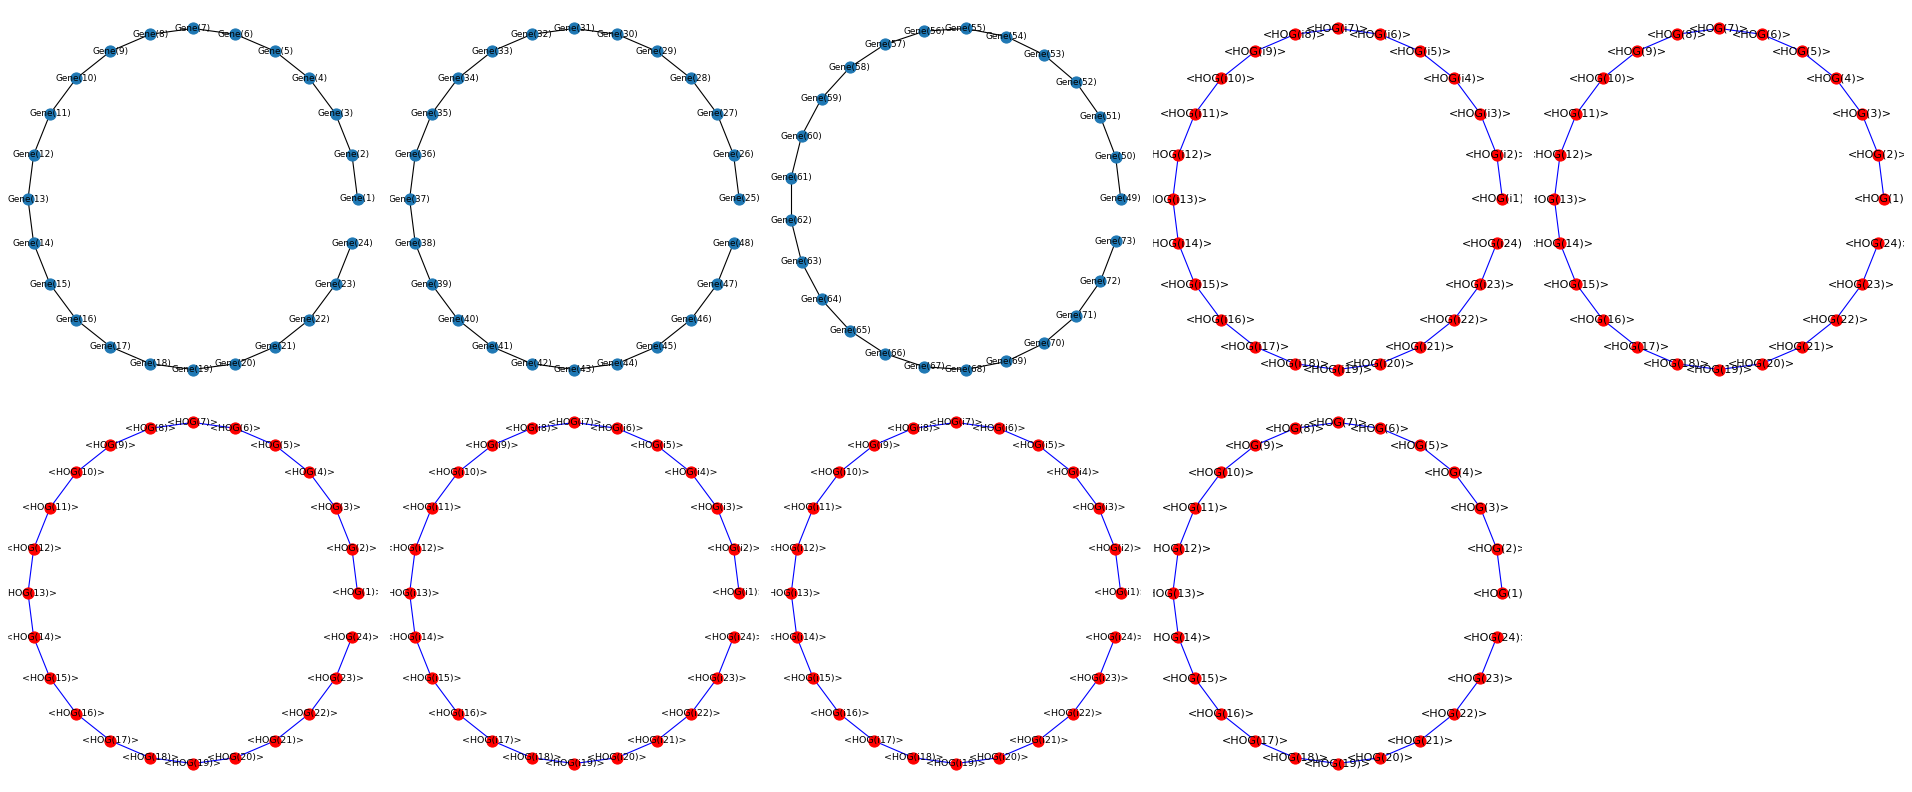

In [290]:
nwk_path = "trying_insertion/manually_made_insertion/RealTree.nwk"
# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")
# Path to OrthoXML file
orthoxml_path = "trying_insertion/manually_made_insertion/Output/HierarchicalGroups.orthoxml"
ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)
get_locus('trying_insertion/manually_made_insertion/DB')


fig=plt.figure(figsize=(24, 10), dpi= 80)
# make the first round of graphs at all nodes

plot_loc = 251
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
    print(tree_node.genome)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
    
  
    
    
    
    
    
    
    ## AND ALSO DO THE SETTLING ALGORITHM   
    settle_path(tree_node)
    
    # If it's an extant gene, doesn't have any weights, plot normally
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=8, node_size=100,
            pos=nx.circular_layout(tree_node.graph[0]))

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1
      
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)

        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), 
            node_color='r', edge_color='w')
        
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        plot_loc += 1
        

plt.tight_layout()
fig.savefig("/Users/kgilbert/Documents/UNIL/SyntenyBasedOrthology/My_SyntOrtho_Code/trying_insertion/manually_made_insertion/outfig_insert_3spp_withSettlingAlgorithm.pdf")

    
    
    
    


### Try the gene duplication case - spp1 gained a gene (gene "3" & "4" are both in hog 3)

In [291]:
nwk_path = "working_dupl_3spp/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
orthoxml_path = "working_dupl_3spp/Output/HierarchicalGroups.orthoxml"

ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

get_locus('working_dupl_3spp/DB')


--SE001_aa
synteny already assigned for extant genome

--SE003_aa
synteny already assigned for extant genome

   /-SE001_aa
--|
   \-SE003_aa
fix problem, there is a polytomy
assign ancestral synteny

--SE002_aa
synteny already assigned for extant genome

      /-SE001_aa
   /-|
--|   \-SE003_aa
  |
   \-SE002_aa
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the parent
an ancestral gene has no parent HOG, don't add synteny in the p

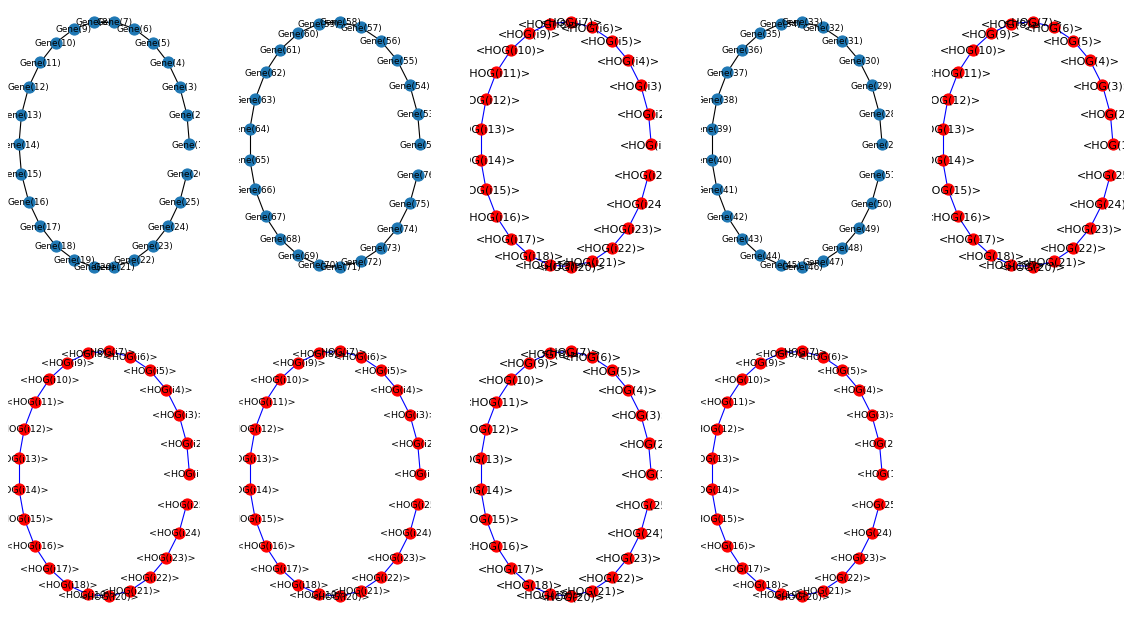

In [292]:
fig=plt.figure(figsize=(18, 10), dpi= 80)
# make the first round of graphs at all nodes

plot_loc = 251
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
#    print(tree_node.genome)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
    
    # If it's an extant gene, doesn't have any weights, plot normally
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=8, node_size=100,
            pos=nx.circular_layout(tree_node.graph[0]))

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1
    
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)     
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), 
            node_color='r', edge_color='w')
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')
        plot_loc += 1

## Try the inversion case - spp1 inverted genes 6-10

In [16]:
nwk_path = "working_inversion_3spp/RealTree.nwk"

# The newick tree is extracted as a string
tree_str = pyham.utils.get_newick_string(nwk_path, type="nwk")

# Path to OrthoXML file
orthoxml_path = "working_inversion_3spp/Output/HierarchicalGroups.orthoxml"

ham_analysis_no_name = pyham.Ham(tree_str, orthoxml_path, use_internal_name=False)

get_locus('working_inversion_3spp/DB')


--SE001_aa
synteny already assigned for extant genome

--SE002_aa
synteny already assigned for extant genome

--SE003_aa
synteny already assigned for extant genome

   /-SE002_aa
--|
   \-SE003_aa
assign ancestral synteny

   /-SE001_aa
--|
  |   /-SE002_aa
   \-|
      \-SE003_aa
assign ancestral synteny
no parent level for topmost node


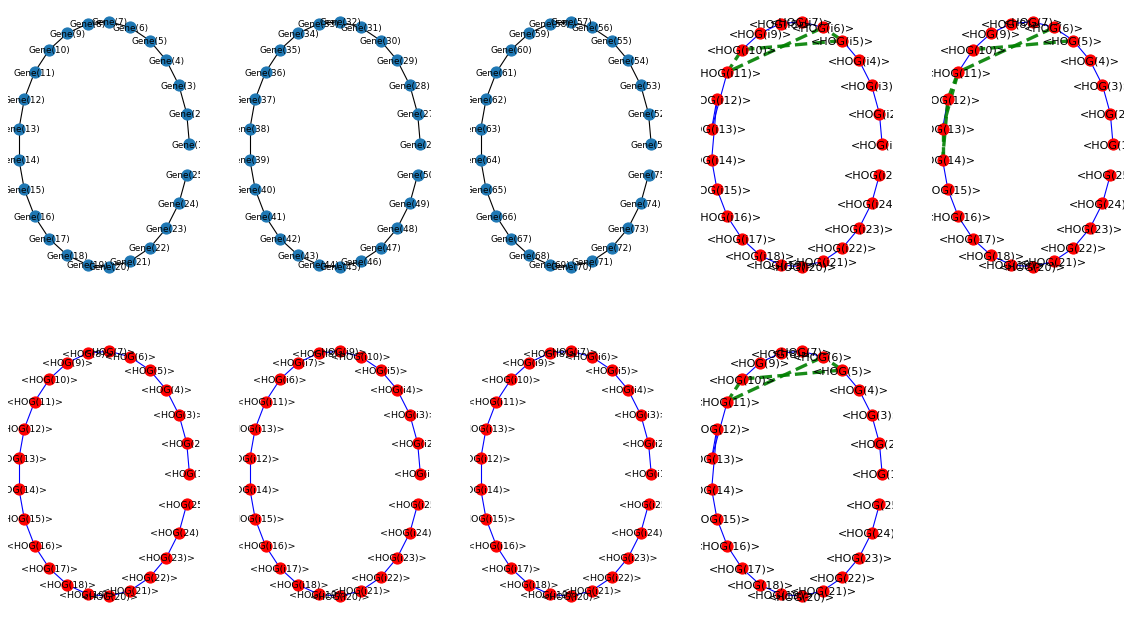

In [17]:
fig=plt.figure(figsize=(18, 10), dpi= 80)
# make the first round of graphs at all nodes

plot_loc = 251
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
    
    print(tree_node)
#    print(tree_node.genome)
    tree_node.graph = make_synteny_graph(tree_node.genome)
    compare_synteny_graphs(tree_node)
    
    # If it's an extant gene, doesn't have any weights, plot normally
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=8, node_size=100,
            pos=nx.circular_layout(tree_node.graph[0]))

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=8.5, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1
    
    # if it's an ancestral genome, plot with the weights
    if isinstance(tree_node.genome, pyham.AncestralGenome):
        plt.subplot(plot_loc)
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[0].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[0]), 
            node_color='r', edge_color='w')
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[0], pos=nx.circular_layout(tree_node.graph[0]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

        if (plot_loc+5) == 260:
            print("no parent level for topmost node")
            break

        plt.subplot(plot_loc+5)     
        large_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] > 1]
        small_edges = [(u, v) for (u, v, d) in tree_node.graph[1].edges(data=True) if d['weight'] <= 1]
        
        # draw the nodes
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
            pos=nx.circular_layout(tree_node.graph[1]), 
            node_color='r', edge_color='w')
        # add the normal edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=large_edges, width=1, edge_color='blue', style='solid')
        # add the weighted / unsettled edges
        nx.draw_networkx_edges(tree_node.graph[1], pos=nx.circular_layout(tree_node.graph[1]), 
                               edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')
        plot_loc += 1

num initial nodes 25
num initial edges 26
num nodes after adding 25
num edges after adding 26


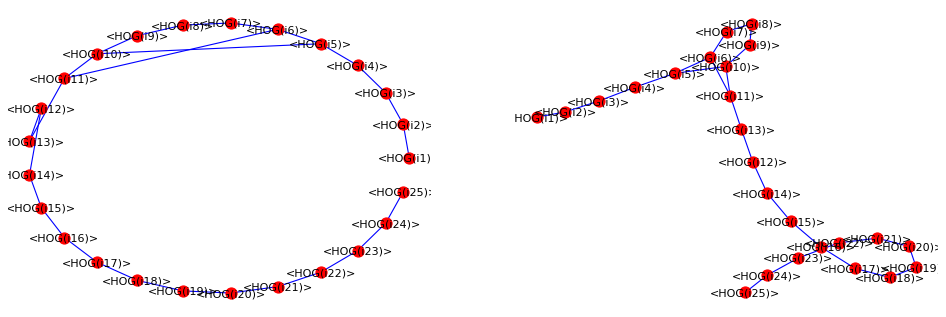

In [18]:
fig=plt.figure(figsize=(15, 11), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
descendants = tree_node.name.split("/")

plt.subplot(221)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), 
        node_color='r', edge_color='b')

# must be an easier way to see the descendant nodes?

descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
# add edges from descendant2
tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)

print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(222)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.spring_layout(tree_node.taxon.graph[0]), 
        node_color='r', edge_color='b')

desc1 initial edges 24
desc2 initial edges 26
num initial nodes 25
num initial edges 28
num nodes after adding 25
num edges after adding 28


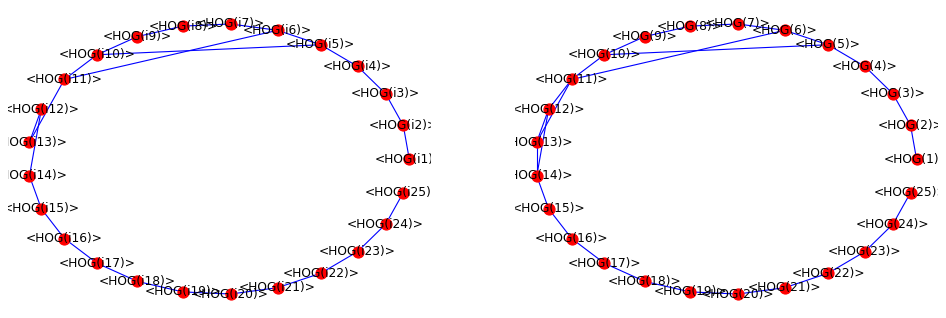

In [19]:
# GO TO THE TOPMOST NODE, MANUALLY
# must be an easier way to see the descendant nodes?

fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE002_aa/SE003_aa")
desc1 = "SE001_aa"
desc2 = "SE002_aa/SE003_aa"

#plt.subplot(121)
#nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
#        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

# must be an easier way to see the descendant nodes?

descendant1 = ham_analysis_no_name.get_extant_genome_by_name(desc1)
descendant2 = ham_analysis_no_name.get_ancestral_genome_by_name(desc2)

print("desc1 initial edges", descendant1.taxon.graph[0].number_of_edges())
print("desc2 initial edges", descendant2.taxon.graph[0].number_of_edges())

plt.subplot(121)
nx.draw(descendant2.taxon.graph[0], with_labels=True, font_weight='normal', font_size=11, node_size=100, 
        pos=nx.circular_layout(descendant2.taxon.graph[0]), node_color='r', edge_color='b')

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
# add edges from descendant2
tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)

print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(122)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=11, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

~

~

## Below this is messy test code

~

~

In [ ]:

# are there any loops?
loop_edges = nx.find_cycle(tree_node.graph[0])
print(loop_edges)
print(len(loop_edges)) # 3 edges in the unsettled loop, they're all the ones with weight 1



#for (u, v, d) in current_graph.edges(data=True):
#    print(u,v,d['weight'])


temp1 = tree_node.graph[0]

# which of those edges came from which descendant?
for edg in loop_edges:
    print(edg)
    #print(current_graph.has_edge(edg[0],edg[1]))
    print(temp1.has_edge(edg[0],edg[1]))

print(temp1.nodes)
test_paths = nx.shortest_simple_paths(temp1, list(temp1.nodes)[0], list(temp1.nodes)[23])    
print("test", list(test_paths))

# keep only the edges that then leave no node out and are the longest path?
##print(tree_node.graph[0].nodes)
##print(tree_node.graph[0].nodes.items)

print(temp1.number_of_edges())
print(temp1.number_of_nodes())
print(temp1.size())
print(temp1.size(weight='weight'))

#list(current_graph.nodes)[0]
#list(current_graph.nodes(data=True))
#list(current_graph.edges(data='weight'))
#list(current_graph.nodes(weight=1))
#list(current_graph.nodes)

#test_paths = nx.shortest_simple_paths(current_graph, '<HOG(i1)>', '<HOG(i25)>')
##test_paths = nx.shortest_simple_paths(current_graph, list(current_graph.nodes)[0], list(current_graph.nodes)[23])
##print("paths", list(test_paths))                              

#for path in list(test_paths):
#    print("length of path", len(path))
#    print("path", path)
    
#print(list(test_paths))

# could look at shared neighbors in the loop?
# sorted(nx.common_neighbors(G, 0, 1))
# or just neighbors?
# G.neighbors(0)


# find these edges in the two descendants to settle the loop

[x for x in temp1.nodes() if temp1.out_degree(x)==0 and temp1.in_degree(x)==1]

In [ ]:


# GO TO THE TOPMOST NODE, MANUALLY
# must be an easier way to see the descendant nodes?

fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE002_aa/SE003_aa")
desc1 = "SE001_aa"
desc2 = "SE002_aa/SE003_aa"

plt.subplot(121)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

# must be an easier way to see the descendant nodes?

descendant1 = ham_analysis_no_name.get_extant_genome_by_name(desc1)
descendant2 = ham_analysis_no_name.get_ancestral_genome_by_name(desc2)

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
# add edges from descendant2
tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)

print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(122)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

In [ ]:
fig=plt.figure(figsize=(18, 10), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE003_aa")
descendants = tree_node.name.split("/")
print(descendants)

plt.subplot(221)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        #pos=nx.spring_layout(tree_node.taxon.graph[0]), 
        node_color='r', edge_color='b')
##print("edges before", tree_node.taxon.graph[0].edges)

current_graph = tree_node.taxon.graph[0]

# must be an easier way to see the descendant nodes?
descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
temp1 = descendant1.taxon.graph[1] # the parent graph of descendant 1
for edg in temp1.edges:
    if current_graph.has_edge(edg[0], edg[1]):
        # we added this one before, just increase the weight by one
        current_graph[edg[0]][edg[1]]['weight'] += 1
    else:
        # new edge. add with weight=1
        current_graph.add_edge(edg[0], edg[1], weight=1)
#tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)

# add edges from descendant2
temp2 = descendant2.taxon.graph[1] # the parent graph of descendant 2
for edg in temp2.edges:
    if current_graph.has_edge(edg[0], edg[1]):
        # we added this one before, just increase the weight by one
        current_graph[edg[0]][edg[1]]['weight'] += 1
    else:
        # new edge. add with weight=1
        current_graph.add_edge(edg[0], edg[1], weight=1)
#tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)                 
                
                
print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(222)
#nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        #pos=nx.circular_layout(tree_node.taxon.graph[0]), 
#        node_color='r', edge_color='b')

#print("edges after", tree_node.taxon.graph[0].edges)
#vars(tree_node.taxon.graph[0])#._adj)
##labels = nx.get_edge_attributes(tree_node.taxon.graph[0],'weight')
##print(labels)


large_edges = [(u, v) for (u, v, d) in current_graph.edges(data=True) if d['weight'] > 1]
small_edges = [(u, v) for (u, v, d) in current_graph.edges(data=True) if d['weight'] <= 1]

nx.draw(current_graph, with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(current_graph), 
        node_color='r', edge_color='w')

#nx.draw_networkx_nodes(current_graph, pos=nx.circular_layout(current_graph), node_size=100, with_labels=True)
nx.draw_networkx_edges(current_graph, pos=nx.circular_layout(current_graph), edgelist=large_edges, width=1, edge_color='blue', style='solid')
nx.draw_networkx_edges(current_graph, pos=nx.circular_layout(current_graph), edgelist=small_edges, width=3, alpha=0.9, edge_color='g', style='dashed')

In [ ]:
fig=plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

## MANUALLY ?? do the internal nodes for now

tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
descendants = tree_node.name.split("/")


print(descendants[0])


plt.subplot(121)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

# must be an easier way to see the descendant nodes?

descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])

##print("desc1", descendant1.taxon.graph[0].edges)
##print("desc1", descendant1.taxon.graph[1].edges)
##print("desc2", descendant2.taxon.graph[0].edges)
##print("desc2", descendant2.taxon.graph[1].edges)

print("num initial nodes", tree_node.taxon.graph[0].number_of_nodes())
print("num initial edges", tree_node.taxon.graph[0].number_of_edges())

# add edges from descendant1
tree_node.taxon.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
# add edges from descendant2
tree_node.taxon.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)

print("num nodes after adding", tree_node.taxon.graph[0].number_of_nodes())
print("num edges after adding", tree_node.taxon.graph[0].number_of_edges())
##print(tree_node.taxon.graph[0].edges)

plt.subplot(122)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', font_size=10, node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

In [ ]:
tree_node = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
descendants = tree_node.name.split("/")

#plt.subplot(121)
nx.draw(tree_node.taxon.graph[0], with_labels=True, font_weight='normal', node_size=100, 
        pos=nx.circular_layout(tree_node.taxon.graph[0]), node_color='r', edge_color='b')

In [ ]:

for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
#    compare_synteny_graphs(tree_node)    
    print(tree_node)
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        print("synteny already assigned for extant genome")
        
    if isinstance(tree_node.genome, pyham.AncestralGenome):
#        print("ancestor", tree_node.graph[0].nodes)
#        print("ancestor.parent", tree_node.graph[1].nodes)
        print("find synteny")
        
        # take this tree node
        # get the descendant tree nodes (and their parent graphs)
        descendants = tree_node.name.split("/")
        if len(descendants) > 2:
            print("need to fix this problem")
        descendant1 = ham_analysis_no_name.get_extant_genome_by_name(descendants[0])
        descendant2 = ham_analysis_no_name.get_extant_genome_by_name(descendants[1])
        #print(descendant1, descendant2)
        #print("desc 1 edges", descendant1.taxon.graph[1].edges)
        
#        test = descendant1.taxon.graph[1].copy()
#        test.remove_nodes_from(n for n in descendant1.taxon.graph[1] if n not in descendant2.taxon.graph[1])
        
        print("num initial nodes", tree_node.graph[0].number_of_nodes())
        print("num initial edges", tree_node.graph[0].number_of_edges())
        
        # add edges from descendant1
        tree_node.graph[0].add_edges_from(descendant1.taxon.graph[1].edges)
        # add edges from descendant2
        tree_node.graph[0].add_edges_from(descendant2.taxon.graph[1].edges)
        
        print("num nodes after adding", tree_node.graph[0].number_of_nodes())
        print("num edges after adding", tree_node.graph[0].number_of_edges())
        print(tree_node.graph[0].edges)
        
        #nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', node_size=100, 
         #       pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')
        # compare the synteny of this graph (0) to the parent graph of the descendants (1)
        # makes two graphs at this level
        # merge the graphs where no conflict
        # leave conflicting edges in as both, and settle them where possible

    #gene2 = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")
    #hog = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

        
# Then you get the corresponding mrca ancestral genomes 
#genome_rodents_3 = ham_analysis.get_ancestral_genome_by_mrca_of_genome_set({genome_rat, genome_mouse})
       

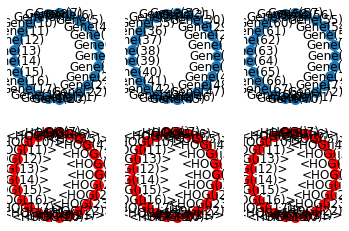

In [179]:
## test initial graphs

plot_loc = 231
for tree_node in ham_analysis_no_name.taxonomy.tree.traverse('postorder'):
# graphs made above    ##tree_node.graph = make_synteny_graph(tree_node.genome)
    if isinstance(tree_node.genome, pyham.ExtantGenome):
        plt.subplot(plot_loc)
        nx.draw(tree_node.graph[0], with_labels=True, font_weight='normal', node_size=100,
                pos=nx.circular_layout(tree_node.graph[0]))#, label="extant network", nlist=[range(5, 10), range(5)])
        #nx.draw(tree_node.graph[1], with_labels=True, font_weight='bold')
        plt.subplot(plot_loc+3)
        nx.draw(tree_node.graph[1], with_labels=True, font_weight='normal', node_size=100, 
                pos=nx.circular_layout(tree_node.graph[1]), node_color='r', edge_color='b')

        plot_loc += 1

    
    
#    if isinstance(tree_node.genome, pyham.ExtantGenome): # then we already have the synteny and all is good
#        print(tree_node.graph.nodes)
#        print("nodes", tree_node.graph.number_of_nodes())
#        print("edges", tree_node.graph.number_of_edges())
        
#    if isinstance(tree_node.genome, pyham.AncestralGenome): # then we want to compare to assign the proper synteny
#        print("ancestor", tree_node.graph[0].nodes)
#        print("ancestor", tree_node.graph[1].nodes)
#        print("ancestor", tree_node.graph[2].nodes)
#        print("nodes", tree_node.graph[0].number_of_nodes())
#        print("edges", tree_node.graph[0].number_of_edges())

##print(ham_analysis_no_name.taxonomy.internal_nodes)
##print(ham_analysis_no_name.taxonomy.leaves)

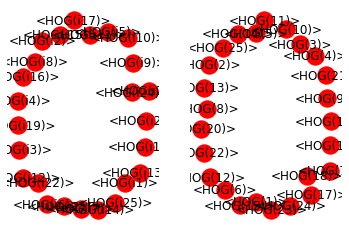

In [156]:
# CURRRENT (ancestral) NETWORK
plt.subplot(121)

test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")
#print(test.taxon.graph)
##vars(test) # show all call-able attributes

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='normal', 
        node_color='r', edge_color='b') # pos=nx.circular_layout(G),

## PARENT NETWORK
plt.subplot(122)

test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='normal', 
        node_color='r', edge_color='b') # pos=nx.circular_layout(G),

In [157]:
vars(test)

{'genes': [<HOG(i1)>,
  <HOG(i2)>,
  <HOG(i3)>,
  <HOG(i4)>,
  <HOG(i5)>,
  <HOG(i6)>,
  <HOG(i7)>,
  <HOG(i8)>,
  <HOG(i9)>,
  <HOG(i10)>,
  <HOG(i11)>,
  <HOG(i12)>,
  <HOG(i13)>,
  <HOG(i14)>,
  <HOG(i15)>,
  <HOG(i16)>,
  <HOG(i17)>,
  <HOG(i18)>,
  <HOG(i19)>,
  <HOG(i20)>,
  <HOG(i21)>,
  <HOG(i22)>,
  <HOG(i23)>,
  <HOG(i24)>,
  <HOG(i25)>],
 'taxon': Tree node 'SE002_aa/SE003_aa' (0x11d3b0b5),
 'name': 'SE002_aa/SE003_aa',
 'ancestral_clustering': None}

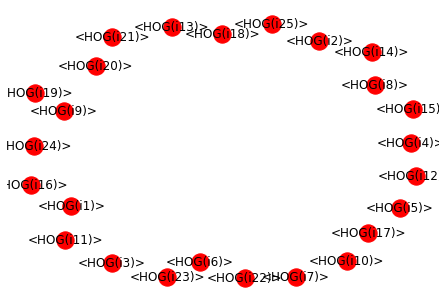

In [147]:
## PARENT NETWORK

test = ham_analysis_no_name.get_ancestral_genome_by_name("SE002_aa/SE003_aa")

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='normal', 
        node_color='r', edge_color='b') # pos=nx.circular_layout(G),


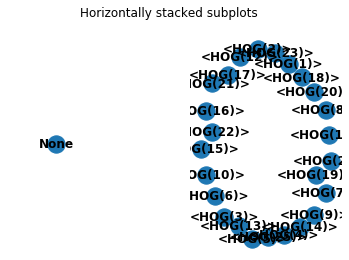

In [145]:
test = ham_analysis_no_name.get_ancestral_genome_by_name("SE001_aa/SE002_aa/SE003_aa")

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('Horizontally stacked subplots')

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')
plt.subplot(131)

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw(test.taxon.graph[2], with_labels=True, font_weight='bold')
#plt.subplot(121)


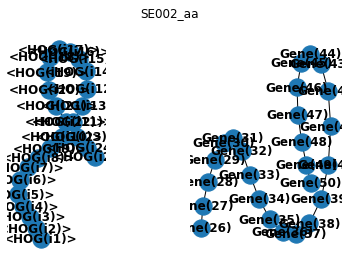

In [146]:
test = ham_analysis_no_name.get_extant_genome_by_name("SE002_aa")

fig, (ax1, ax2) = plt.subplots(1,2)
fig.suptitle('SE002_aa')

nx.draw(test.taxon.graph[0], with_labels=True, font_weight='bold')
plt.subplot(131)

nx.draw(test.taxon.graph[1], with_labels=True, font_weight='bold')
#plt.subplot(122)
#nx.draw(test.taxon.graph[2], with_labels=True, font_weight='bold')
#plt.subplot(121)